<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [256]:
import tensorflow as tf
import glob
import matplotlib.pyplot as plt 
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
from matplotlib import rc
import numpy as np
import scipy.stats as sp
from cycler import cycler

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import os, sys
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
from matplotlib import rc
%matplotlib inline

np.set_printoptions(threshold=sys.maxsize)
plt.rc('font', size=10)
plt.rcParams["font.family"] = "Times New Roman" 

In [15]:
lite = False

In [284]:
def read_data(tf_dir, tag="return_mean", MAX_HORIZON=1000000000):

    list_of_data = []

    tf_files = glob.glob(tf_dir + "events.out.tfevents*")

    for tf_file in tf_files:
        done = False
        data = []
        frames = []

        for e in tf.train.summary_iterator(tf_file):
            for v in e.summary.value:
                if v.tag == "frames":
                    frames.append(v.simple_value)
                    if v.simple_value > MAX_HORIZON:
                        done = True
                elif v.tag == tag:
                    data.append(v.simple_value)
            if done:
                break

        data = data[:min(len(frames), len(data))]
        frames = frames[:min(len(frames), len(data))]

        if len(data) != 0:
            list_of_data.append((data, frames))

    list_of_data = sorted(list_of_data, key=(lambda pair: min(pair[1])))

    cleaned_frames = []
    cleaned_data = []
    max_frames = 0
    for (data, frames) in list_of_data:
        for i in range(len(data)):
            if frames[i] < max_frames:
                continue
            else:
                max_frames = frames[i]
                cleaned_frames.append(frames[i])
                cleaned_data.append(data[i])


    # Cumulative sum smoothing
    window_width = 10
    cumsum_vec = np.cumsum(np.insert(cleaned_data, 0, 0)) 
    ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
    return cleaned_frames[:len(ma_vec)], ma_vec

In [285]:
# Returns (X_data, (Y_average, Y_error))
def read_data_and_average(tf_dirs, tag="return_mean", MAX_HORIZON=1000000000):
    X_all = None
    Ys = []

    if lite:
        tf_dirs = tf_dirs[:1]
    for tf_dir in tf_dirs:
        X, Y = read_data(tf_dir, tag, MAX_HORIZON)

        Ys.append(Y)
        if X_all is None:
            X_all = X
        else:
            if len(X) < len(X_all):
                X_all = X
        # print(tf_dir, len(Y))

    N = min([len(Ys[i]) for i in range(len(Ys))])
    M = len(Ys)
    print(M, N, [len(Ys[i]) for i in range(len(Ys))])
    

    avgs = [0 for i in range(N)]
    lower = [0 for i in range(N)]
    upper = [0 for i in range(N)]

    for n in range(N):
        vals = []
        for m in range(M):
            vals.append(Ys[m][n])

        vals = np.array(vals)
        if M == 1:
            lo = hi = np.mean(vals)
        else:
            lo, hi = sp.t.interval(0.9, len(vals)-1, loc=np.mean(vals), scale=sp.sem(vals))

        avgs[n] = (lo+hi)/2
        lower[n] = lo
        upper[n] = hi

    return X_all, avgs, lower, upper

In [399]:
# col = {
#     "GNN+progression+pretraining": "#6E5499",
#     "GNN+progression": "#6E5499", 
    
#     "GRU+progression+pretraining": "#D83B2D",
#     "GRU+progression": "#D83B2D", 
#     "GRU": "#AB5164",
    
#     "LSTM+progression": "#88B8CD", 
    
#     "Myopic": "#E7DC66", 
    
#     "No LTL": "black"
# }

col = {
    "GNN+progression+pretraining": "#294773", #"#485466",
    "GNN+progression": "#294773", 
    
    "GRU+progression+pretraining": "#CF4A43",
    "GRU+progression": "#CF4A43", 
    "GRU": "#D4CDC1",
    
    "LSTM+progression": "#7BB76D", 
    
    "Myopic": "#E5B936", 
    
    "No LTL": "black"
}

def style(label):
    if "pretraining" in label:
        return "dotted"
    elif "No LTL" == label:
        return "--"
    else:
        return "-"

    
def plot_ax(ax, logs, ylabel, labels, title, horizon, xlim=None, ylim=None, ncol=2, show_label=True):
    if(show_label): ax.set_ylabel(ylabel, fontsize = 16)
    ax.yaxis.tick_right()
    if (show_label): ax.set_xlabel("Frames (millions)", fontsize = 16)
    ax.tick_params(labelsize=12, direction="in", length=8, grid_alpha=0.9)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.grid(True)
    if (title != "" and show_label):
        ax.set_title(title, fontsize = 16)

    for data_line, label in zip(logs, labels):
        X, Y_avg, Y_lower, Y_upper = read_data_and_average(data_line, tag="average_discounted_return", MAX_HORIZON=horizon) #average_discounted_return, average_discounted_return, average_reward_per_step
        X = [x / 1000000 for x in X]
        label_legend = label if(show_label) else "           "
        ax.plot(X, Y_avg, linewidth = 2, label=label_legend, color=col[label], linestyle=style(label))
        ax.fill_between(X, Y_lower, Y_upper, alpha=0.2, color=col[label])
        handles, labels = ax.get_legend_handles_labels()
#         ax.legend(handles, labels, loc="lower right", markerscale=6, fontsize=20, ncol = ncol)#, loc="lower center",bbox_to_anchor = (0.5, 0), markerscale=6, fontsize=16, ncol = 3)
        
        ax.set_xlim(left=0, right=xlim)
        ax.set_ylim(top=ylim)
            

30 967 [967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 968, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 968, 967, 967]
30 967 [967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967]
30 955 [965, 967, 961, 960, 967, 967, 964, 967, 955, 967, 967, 962, 967, 962, 957, 961, 962, 967, 967, 963, 962, 957, 967, 962, 967, 967, 960, 956, 967, 967]
30 967 [967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967]
30 967 [967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967, 967]
30 965 [967, 968, 966, 966, 967, 967, 967, 967, 967, 966, 967, 967, 967, 967, 967, 967, 967, 968, 967, 965, 967, 967, 967, 967, 968, 967, 967, 966, 969, 967]
30 967 [967, 967, 967, 967, 967, 967, 967, 967, 967,

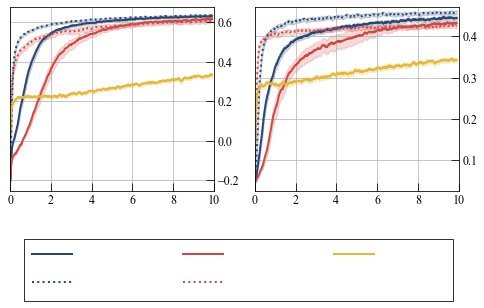

In [400]:
def plot_pretraining_experiments():
    until_logs = [glob.glob("../storage/storage-good/RGCN/*Until_1_3_1_2*/train/"),
                    glob.glob("../storage/transfer-storage/RGCN/*pretrained_Until_1_3_1_2*/train/"),
                    glob.glob("../storage/storage-good/GRU/*Until_1_3_1_2*/train/"),
                    glob.glob("../storage/transfer-storage/GRU/*pretrained_Until_1_3_1_2*/train/"),
                    glob.glob("../storage/storage-good/Myopic/*Until*/train/")
                ]


    eventually_logs = [glob.glob("../storage/storage-good/RGCN/*Eventually_1_5_1_4*/train/"),
                    glob.glob("../storage/transfer-storage/RGCN/*pretrained_Eventually_1_5_1_4*/train/"),
                    glob.glob("../storage/storage-good/GRU/*Eventually_1_5_1_4*/train/"),
                    glob.glob("../storage/transfer-storage/GRU/*pretrained_Eventually_1_5_1_4*/train/"),
                    glob.glob("../storage/storage-good/Myopic/*Eventually*/train/")
                ]

    labels = ["GNN+progression", "GNN+progression+pretraining", "GRU+progression", "GRU+progression+pretraining",   "Myopic"]
    horizon = 10000000

    fig, (ax1, ax2) = plt.subplots(1, 2)
    plt.subplots_adjust(top = 0.92, bottom = 0.28, hspace = 0, wspace = 0.2, left=0.07, right = 0.96)
    fig.set_size_inches(7,4)
    
    for ax, logs, title in [(ax1, until_logs, "Avoidance Tasks"), (ax2, eventually_logs, "Partially-Ordered Tasks")]:
        plot_ax(ax, logs, "Discounted return", labels, title, horizon, horizon/1e6, ncol=1, show_label=False)

    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles, labels, loc="lower center",edgecolor="black", shadow=False, fancybox=False, bbox_to_anchor = (-0.08, -0.65), markerscale=1, fontsize=20, ncol = 3)#, )  
    plt.savefig("transfer.pdf", bbox_inches = 'tight', pad_inches = 0.1)
    
    plt.show()
    
plot_pretraining_experiments()

30 1941 [1944, 1945, 1944, 1945, 1944, 1943, 1944, 1944, 1945, 1944, 1942, 1945, 1944, 1941, 1944, 1945, 1943, 1945, 1944, 1943, 1945, 1942, 1945, 1942, 1944, 1945, 1945, 1944, 1944, 1944]
30 1924 [1941, 1944, 1938, 1937, 4875, 1944, 1941, 1944, 1924, 4874, 4875, 1939, 1944, 1939, 1931, 1935, 1939, 1944, 1944, 1939, 1933, 1934, 4866, 1931, 1944, 1934, 1937, 1933, 1944, 4874]
30 1935 [1939, 1938, 1941, 1939, 1944, 1943, 1944, 1944, 1939, 1938, 1944, 1944, 1941, 1944, 1942, 1944, 1942, 1944, 1941, 1944, 1944, 1940, 1944, 1941, 1944, 1944, 1940, 1935, 1944, 1944]
30 1944 [1944, 4874, 1944, 1944, 4874, 1944, 4874, 1944, 1944, 1944, 1944, 4875, 1944, 1944, 1944, 1944, 4874, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944]
30 1944 [1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944]
30 1944 [1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944

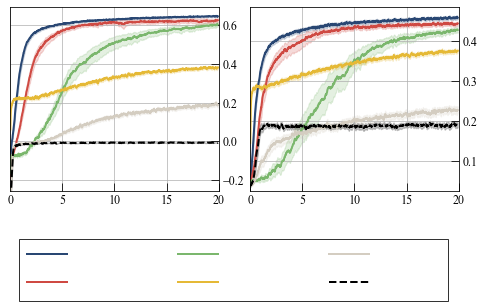

In [392]:
def plot_letter_env_experiments():
    until_logs = [glob.glob("../storage/storage-good/RGCN/*Until*/train/"),
                    glob.glob("../storage/storage-good/GRU/*Until*/train/"),
                    glob.glob("../storage/storage-good/LSTM/*Until*/train/"),
                    glob.glob("../storage/storage-good/Myopic/*Until*/train/"),
                    glob.glob("../storage/storage-good/GRU-no-progression/*Until*/train/"),
                    glob.glob("../storage/storage-good/No-LTL/*Until*/train/")
                ]

    eventually_logs = [glob.glob("../storage/storage-good/RGCN/*Eventually*/train/"),
                    glob.glob("../storage/storage-good/GRU/*Eventually*/train/"),
                    glob.glob("../storage/storage-good/LSTM/*Eventually*/train/"),
                    glob.glob("../storage/storage-good/Myopic/*Eventually*/train/"),
                    glob.glob("../storage/storage-good/GRU-no-progression/*Eventually*/train/"),
                    glob.glob("../storage/storage-good/No-LTL/*Eventually*/train/")
                ]

    
    
    labels = ["GNN+progression", "GRU+progression", "LSTM+progression", "Myopic", "GRU", "No LTL"]
    horizon = 20000000000

    fig, (ax1, ax2) = plt.subplots(1, 2)
    plt.subplots_adjust(top = 0.92, bottom = 0.28, hspace = 0, wspace = 0.15, left=0.07, right = 0.96)
    fig.set_size_inches(7,4)
    
    for ax, logs, title in [(ax1, until_logs, "Avoidance Tasks"), (ax2, eventually_logs, "Partially-Ordered Tasks")]:
        plot_ax(ax, logs, "Discounted return", labels, title, horizon, horizon/1e9, show_label=False)

    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles, labels, loc="lower center",edgecolor="black", shadow=False, fancybox=False, bbox_to_anchor = (-0.08, -0.65), markerscale=1, fontsize=20, ncol = 3)#, )  
    plt.savefig("letter-env.pdf", bbox_inches = 'tight', pad_inches = 0.1)
    plt.show()
    
plot_letter_env_experiments()

30 296 [305, 297, 296, 296, 299, 299, 296, 299, 296, 296, 297, 296, 301, 299, 296, 300, 296, 300, 297, 298, 296, 301, 296, 298, 297, 298, 299, 300, 296, 298]
30 295 [301, 296, 296, 296, 299, 297, 299, 296, 298, 299, 296, 296, 303, 296, 300, 297, 298, 298, 298, 296, 296, 297, 296, 296, 296, 295, 299, 296, 296, 301]
30 295 [297, 297, 296, 298, 297, 300, 296, 296, 297, 298, 295, 298, 296, 296, 299, 297, 296, 296, 296, 296, 299, 296, 298, 299, 296, 298, 297, 297, 298, 296]


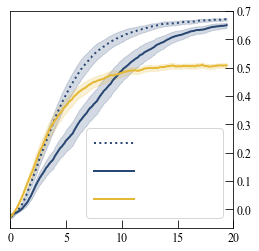

In [320]:
def plot_safety_experiments():
    A_logs = glob.glob("../storage/zone-good/pretrained/*/train/")
    B_logs = glob.glob("../storage/zone-good/RGCN/*/train/")
    C_logs = glob.glob("../storage/zone-good/myopic/*/train/")
    
    logs = [A_logs, B_logs, C_logs]
    labels = ["GNN+progression+pretraining", "GNN+progression", "Myopic"]

    horizon = 20000000

    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(4,4)
    
    plot_ax(ax1, logs, "Discounted return", labels, "Avoidance Tasks", horizon, horizon/1e6, ylim=0.7, ncol=1, show_label=False)
#     plot_ax(ax1, logs, "", labels, "", horizon, horizon/1e6, ylim=0.7, ncol=1, show_label=False)
    
    plt.savefig("safety.pdf", bbox_inches = 'tight', pad_inches = 0.1)
    
    plt.show()
    
plot_safety_experiments()

12 174 [174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174]
12 174 [174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174]


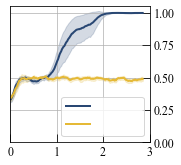

In [325]:
def plot_ax_toy(ax, logs, ylabel, labels, title, horizon, xlim, ncol=2, show_label=True):
    if(show_label): ax.set_ylabel(ylabel, fontsize = 16)
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    
    if (show_label): ax.set_xlabel("Frames (millions)", fontsize = 16)
    ax.tick_params(labelsize=12, direction="in", length=8, grid_alpha=0.9)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    if (title != "" and show_label):
        ax.set_title(title, fontsize = 16)

    for data_line, label in zip(logs, labels):
        X, Y_avg, Y_lower, Y_upper = read_data_and_average(data_line, tag="return_mean", MAX_HORIZON=horizon)
        X = [x / 1000000 for x in X]
        label_legend = label if(show_label) else "             "
        ax.plot(X, Y_avg, linewidth = 2, label=label_legend, color=col[label], linestyle=style(label))
        ax.fill_between(X, Y_lower, Y_upper, alpha=0.2, color=col[label])
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, loc="lower right", markerscale=6, fontsize=12, ncol = ncol)#, loc="lower center",bbox_to_anchor = (0.5, 0), markerscale=6, fontsize=16, ncol = 3)
        ax.grid(True)
        ax.set_xlim(left=0, right=xlim)
        ax.set_ylim(bottom=0)

def plot_toy_experiments():
    # Toy

    A_logs = glob.glob("../storage/toy-minigrid/RGCN/*/train/")
    B_logs = glob.glob("../storage/toy-minigrid/myopic/*/train/")
    

    logs = [A_logs, B_logs]
    labels = ["GNN+progression", "Myopic"]
    horizon = 3000000

    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(2.5,2.5)
    
    plot_ax_toy(ax1, logs, "Total reward", labels, "", horizon, horizon/1e6, ncol=1, show_label=False)
    
    plt.savefig("toy.pdf", bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    
plot_toy_experiments()

30 1212 [1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212]
30 1212 [1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212]
30 1212 [1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1213, 1212, 1212, 1213, 1212, 1212, 1212, 1212, 1212, 1212, 1213, 1213, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1213, 1212]
30 1212 [1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1213, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212, 1212]


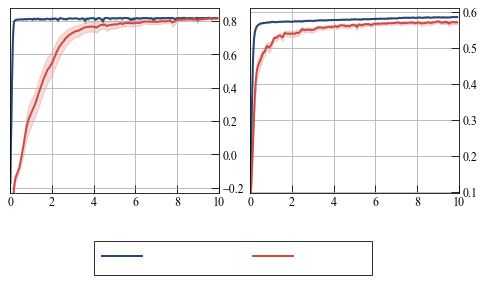

In [18]:
def plot_pretraining_only_curves():
    # Pretraining curves (not the results from the target environment -- if you're looking
    # for that, go to function "plot_pretraining_experiments()")

    until_logs = [glob.glob("../symbol-storage/RGCN/*Until_1_3_1_2*/train/"),
                    glob.glob("../symbol-storage/GRU/*Until_1_3_1_2*/train/"),
                ]

    eventually_logs = [glob.glob("../symbol-storage/RGCN/*Eventually_1_5_1_4*/train/"),
                    glob.glob("../symbol-storage/GRU/*Eventually_1_5_1_4*/train/"),
                ]
    labels = ["GNN+progression", "GRU+progression"]
    horizon = 10000000000

    fig, (ax1, ax2) = plt.subplots(1, 2)
    plt.subplots_adjust(top = 0.92, bottom = 0.28, hspace = 0, wspace = 0.15, left=0.07, right = 0.96)
    fig.set_size_inches(7,4)
    
    for ax, logs, title in [(ax1, until_logs, "Avoidance Tasks"), (ax2, eventually_logs, "Partially-Ordered Tasks")]:
        plot_ax(ax, logs, "Discounted return", labels, title, horizon, horizon/1e9, show_label=False)

    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles, labels, loc="lower center",edgecolor="black", shadow=False, fancybox=False, bbox_to_anchor = (-0.08, -0.5), markerscale=1, fontsize=20, ncol = 3)#, )  
    plt.savefig("pretraining-curves.pdf", bbox_inches = 'tight', pad_inches = 0.1)
    plt.show()
    
plot_pretraining_only_curves()